# **Medical Image Segmentation**

In [1]:
# First, import the necessary modules

import skimage as sk
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.gridspec import GridSpec

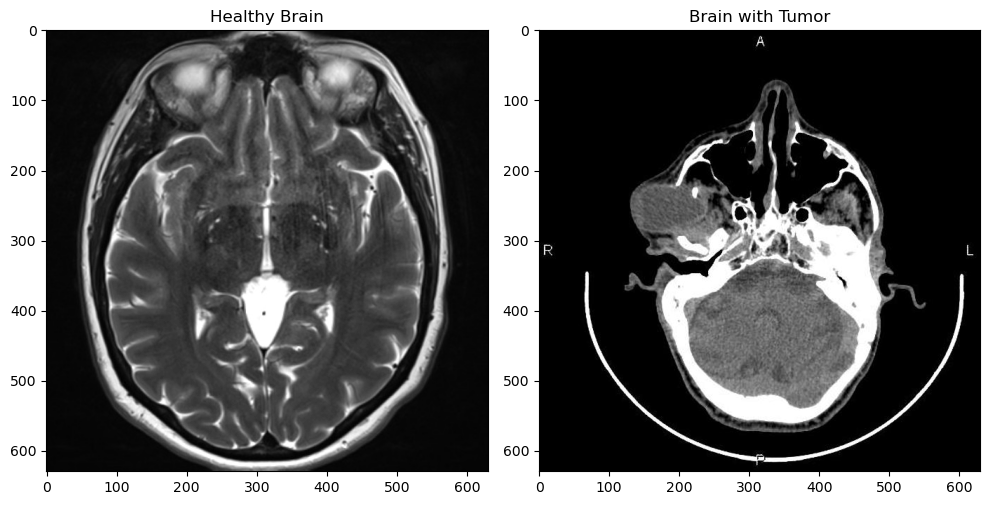

In [2]:
# Next, import the images
healthy_brain = sk.io.imread("/Users/aringhorui/Downloads/Cerebral.jpeg", as_gray=True)  
tumor_brain = sk.io.imread("/Users/aringhorui/Downloads/Tumor.jpeg", as_gray=True)

# Now let's visualize the imported images
fig = plt.figure(figsize=(10, 9))

gs = GridSpec(1, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

ax0.imshow(healthy_brain, cmap='gray')
ax0.set_title('Healthy Brain')
ax1.imshow(tumor_brain, cmap='gray')
ax1.set_title('Brain with Tumor')
plt.tight_layout()
plt.plot()
plt.show()

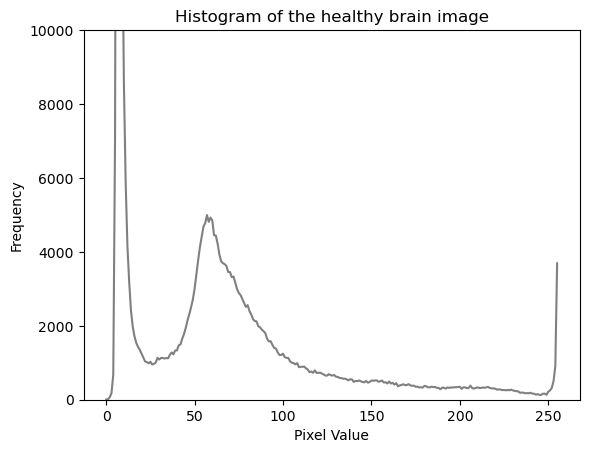

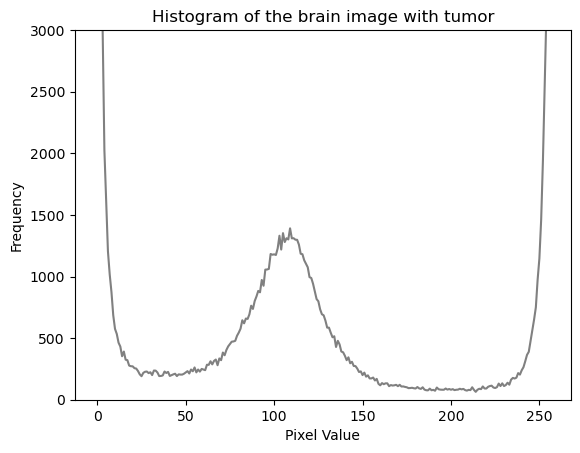

In [3]:
# Calculate histograms for brain image and tumor image
brain_histogram, _ = np.histogram(healthy_brain.flatten(), bins=256, range=(0, 256))  # Calculate histogram for the healthy brain image
tumor_histogram, _ = np.histogram(tumor_brain.flatten(), bins=256, range=(0, 256))  # Calculate histogram for the brain image with tumor

# Display the histograms
plt.title("Histogram of the healthy brain image")
print()
plt.ylim(0,10000)
plt.plot(brain_histogram, color="gray")

plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()
print()
plt.title("Histogram of the brain image with tumor")
plt.ylim(0,3000)
plt.plot(tumor_histogram, color="gray")

plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

##Thresholding

##Otsu's Method

In [4]:
def compute_otsu_criteria(image, threshold):
    # Create the thresholded image
    thresholded_image = np.zeros(image.shape)
    thresholded_image[image >= threshold] = 1

    # Compute weights
    total_pixels = image.size
    pixels_above_threshold = np.count_nonzero(thresholded_image)
    weight_above_threshold = pixels_above_threshold / total_pixels
    weight_below_threshold = 1 - weight_above_threshold

    # If one of the classes is empty, that threshold will not be considered
    if weight_above_threshold == 0 or weight_below_threshold == 0:
        return np.inf

    # Find all pixels belonging to each class
    pixels_above = image[thresholded_image == 1]
    pixels_below = image[thresholded_image == 0]

    # Compute variance of these classes
    variance_above = np.var(pixels_above) if len(pixels_above) > 0 else 0
    variance_below = np.var(pixels_below) if len(pixels_below) > 0 else 0

    return weight_below_threshold * variance_below + weight_above_threshold * variance_above


def otsuThresholding(image):
    threshold_range = range(np.max(image) + 1)
    criterias = []

    for t in threshold_range:
      criteria = compute_otsu_criteria(image, t)
      criterias.append(criteria)

    criterias = np.array(criterias)

    # Best threshold is the one minimizing the Otsu criteria
    best_threshold = threshold_range[np.argmin(criterias)]

    binary = np.zeros_like(image)
    binary[image > best_threshold] = 255

    return best_threshold

In [5]:
otsu_brain = otsuThresholding(healthy_brain)
otsu_tumor = otsuThresholding(tumor_brain)

print("Otsu threshold for healthy brain:", otsu_brain)
print("Otsu threshold for tumor image:", otsu_tumor)

Otsu threshold for healthy brain: 104
Otsu threshold for tumor image: 86


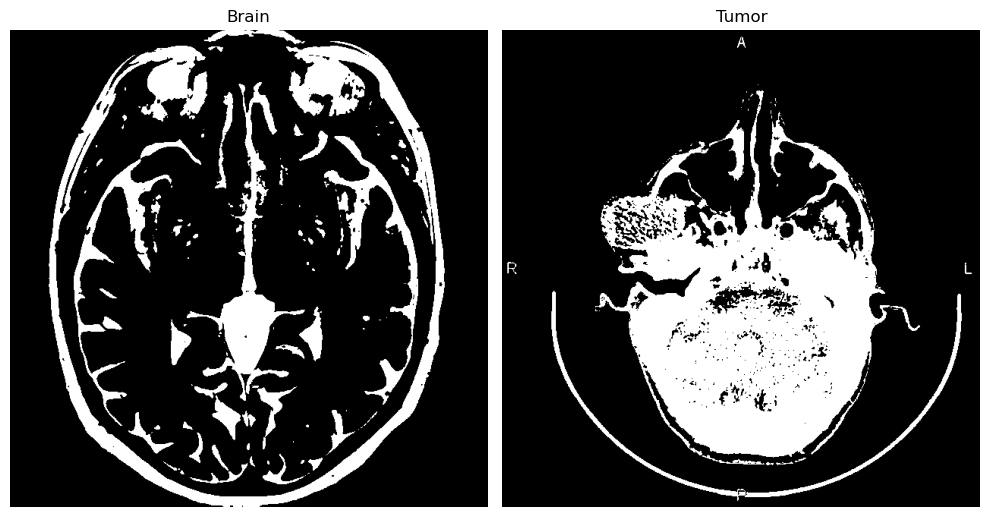

In [6]:
otsu_brain_binarized = (healthy_brain > otsu_brain).astype(np.uint8) * 255
otsu_tumor_binarized = (tumor_brain > otsu_tumor).astype(np.uint8) * 255

# Display the binarized images
fig = plt.figure(figsize=(10, 9))

gs = GridSpec(1, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

ax0.imshow(otsu_brain_binarized, cmap='gray')
ax0.set_title('Brain')
ax1.imshow(otsu_tumor_binarized, cmap='gray')
ax1.set_title('Tumor')
for a in (ax0, ax1):
    a.axis('off')
plt.tight_layout()
plt.plot()
plt.show()

### Region Segmentation



> Flood Fill



In [7]:
def flood_fill(image, seed_point, new_value, tolerance):
    height, width = image.shape
    stack = [seed_point]
    target_value = image[seed_point[0], seed_point[1]]
    visited = np.zeros_like(image, dtype=bool)

    while stack:
        x, y = stack.pop()

        if not (0 <= x < height and 0 <= y < width):
            continue

        if visited[x, y] or abs(image[x, y] - target_value) > tolerance:
            continue

        visited[x, y] = True
        image[x, y] = new_value
        stack.extend([(x+1, y), (x-1, y), (x, y+1), (x, y-1)])

    return image

/var/folders/t4/d3p1kdtx0vg8t_v9svmw8bs40000gn/T/ipykernel_27908/1869371782.py:13: RuntimeWarning: overflow encountered in scalar subtract
  if visited[x, y] or abs(image[x, y] - target_value) > tolerance:


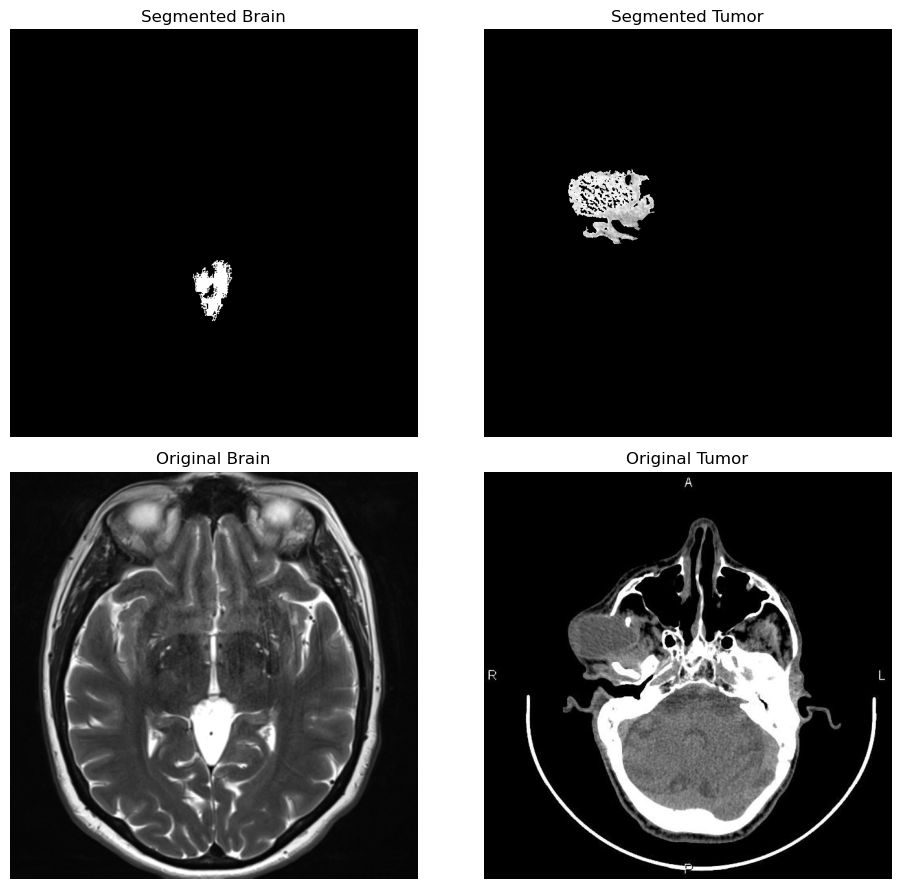

In [8]:
# Segmenting the healthy brain image
seed_point_brain = (400, 300)
tolerance_brain = otsu_brain
new_value_brain = 0

seg_brain = flood_fill(healthy_brain.copy(), seed_point_brain, new_value_brain, tolerance_brain)
diff_brain1 = healthy_brain - seg_brain

# Segmenting the brain tumor image
seed_point_tumor = (250, 200)
tolerance_tumor = otsu_tumor
new_value_tumor = 0

seg_tumor = flood_fill(tumor_brain.copy(), seed_point_tumor, new_value_tumor, tolerance_tumor)
diff_tumor1 = seg_tumor - tumor_brain

fig = plt.figure(figsize=(10, 9))
gs = GridSpec(2, 2)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])

ax0.imshow(diff_brain1, cmap='gray')
ax0.set_title('Segmented Brain')
ax1.imshow(diff_tumor1, cmap='gray')
ax1.set_title('Segmented Tumor')
ax2.imshow(healthy_brain, cmap='gray')
ax2.set_title('Original Brain')
ax3.imshow(tumor_brain, cmap='gray')
ax3.set_title('Original Tumor')

for a in (ax0, ax1, ax2, ax3):
    a.axis('off')

plt.tight_layout()
plt.show()




> Gaussian Filter Smoothening



In [9]:
def gaussian_smooth(image, kernel_size=3, sigma=1):
    height, width = image.shape
    smoothed_image = np.zeros_like(image, dtype=np.float64)
    pad = kernel_size // 2

    # Create Gaussian kernel
    kernel = np.zeros((kernel_size, kernel_size), dtype=np.float64)
    for i in range(-pad, pad + 1):
        for j in range(-pad, pad + 1):
            kernel[i + pad, j + pad] = (1/(2*3.1415*sigma**2))*np.exp(-(i**2 + j**2) / (2 * sigma**2))
    kernel /= np.sum(kernel)

    # Perform convolution with the Gaussian kernel
    for i in range(pad, height - pad):
        for j in range(pad, width - pad):
            smoothed_image[i, j] = np.sum(image[i - pad:i + pad + 1, j - pad:j + pad + 1] * kernel)

    return smoothed_image.astype(np.uint8)

/var/folders/t4/d3p1kdtx0vg8t_v9svmw8bs40000gn/T/ipykernel_27908/1869371782.py:13: RuntimeWarning: overflow encountered in scalar subtract
  if visited[x, y] or abs(image[x, y] - target_value) > tolerance:


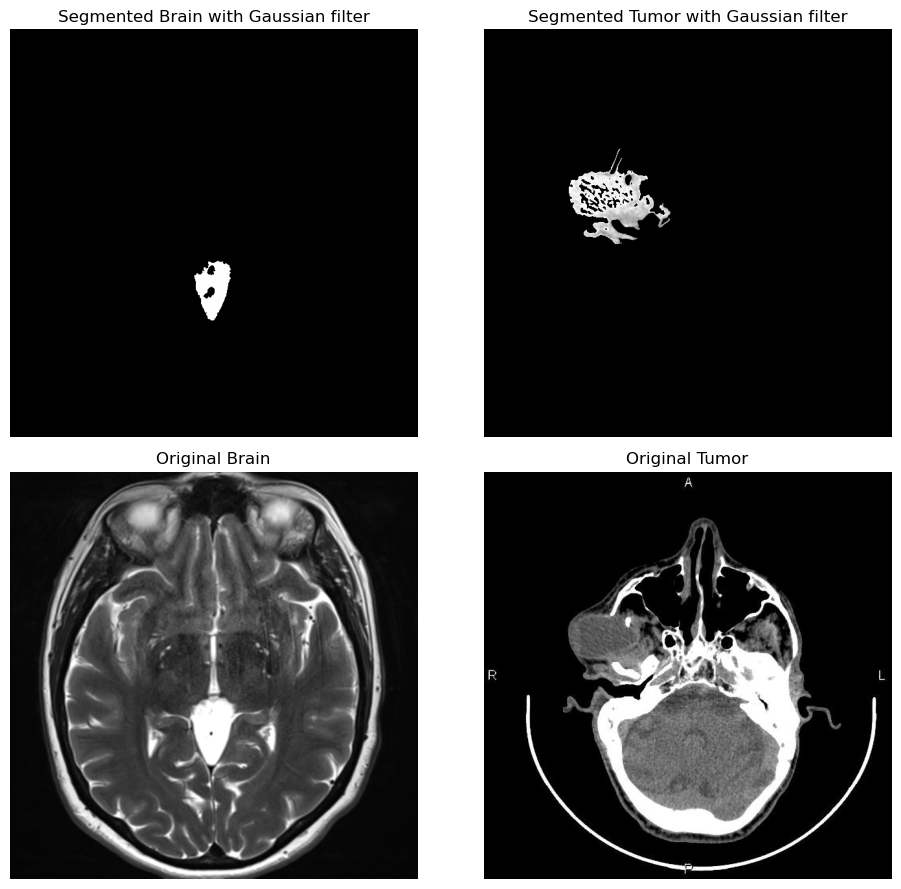

In [10]:
# Smoothing the images with a custom Gaussian filter
brain_gaussian = gaussian_smooth(healthy_brain, kernel_size=11, sigma=1)
tumor_gaussian = gaussian_smooth(tumor_brain, kernel_size=11, sigma=1)

# Segmenting the brain image smoothed with a custom Gaussian filter
seg_brain_gaussian = flood_fill(brain_gaussian.copy(), seed_point_brain, new_value_brain, tolerance_brain)
diff_brain = brain_gaussian - seg_brain_gaussian

# Segmenting the tumor image smoothed with a custom Gaussian filter
seg_tumor_gaussian = flood_fill(tumor_gaussian.copy(), seed_point_tumor, new_value_tumor, tolerance_tumor)
diff_tumor = seg_tumor_gaussian - tumor_gaussian

fig = plt.figure(figsize=(10, 9))

gs = GridSpec(2, 2)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])

ax0.imshow(diff_brain, cmap='gray')
ax0.set_title('Segmented Brain with Gaussian filter')
ax1.imshow(diff_tumor, cmap='gray')
ax1.set_title('Segmented Tumor with Gaussian filter')
ax2.imshow(healthy_brain, cmap='gray')
ax2.set_title('Original Brain')
ax3.imshow(tumor_brain, cmap='gray')
ax3.set_title('Original Tumor')

for a in (ax0, ax1, ax2, ax3):
    a.axis('off')

plt.tight_layout()
plt.plot()
plt.show()


<span style="font-size:45px;">Window Segmentation </span>



In [11]:
def equalize_hist(image):
    histogram, _ = np.histogram(image.flatten(), bins=256, range=(0, 256))

    # Compute cumulative distribution function (CDF)
    cdf = np.cumsum(histogram)

    # Normalize CDF
    cdf_normalized = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())

    # Interpolate histogram values
    equalized_image = np.interp(image.flatten(), range(256), cdf_normalized).reshape(image.shape)

    return equalized_image.astype(np.uint8)

/var/folders/t4/d3p1kdtx0vg8t_v9svmw8bs40000gn/T/ipykernel_27908/1869371782.py:13: RuntimeWarning: overflow encountered in scalar subtract
  if visited[x, y] or abs(image[x, y] - target_value) > tolerance:


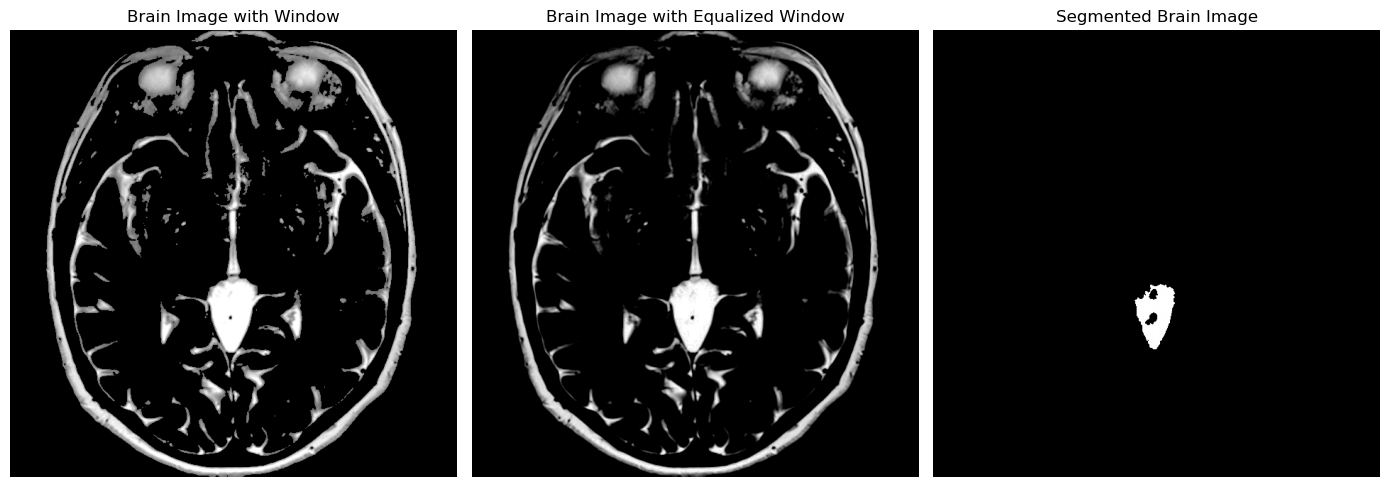

In [12]:
# Apply windowing
w_brain = np.where(healthy_brain <= 104, 0, healthy_brain)
w_brain = np.uint8(w_brain)

# Equalize the windowed image
brain_eq = equalize_hist(w_brain)

# Segment the equalized windowed image using flood fill
seg_brain_w = flood_fill(brain_eq.copy(), seed_point_brain, new_value_brain, tolerance_brain)
diff_brain2 = brain_eq - seg_brain_w

# Display the images
fig = plt.figure(figsize=(14, 12))

gs = GridSpec(1, 3)
ax0 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[0,1])
ax1 = fig.add_subplot(gs[0,2])

ax0.imshow(w_brain, cmap='gray')
ax0.set_title('Brain Image with Window')
ax1.imshow(diff_brain, cmap='gray')
ax1.set_title('Segmented Brain Image')
ax3.imshow(brain_eq, cmap='gray')
ax3.set_title('Brain Image with Equalized Window')

for a in (ax0, ax1, ax3):
    a.axis('off')

plt.tight_layout()
plt.plot()
plt.show()

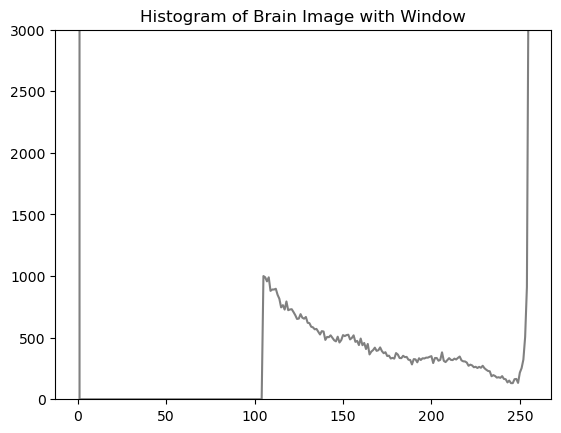

In [13]:
h1, _ = np.histogram(w_brain.flatten(), bins=256, range=(0, 256))
plt.plot(h1, color="gray")
plt.title("Histogram of Brain Image with Window")
plt.ylim(0,3000)
plt.show()

/var/folders/t4/d3p1kdtx0vg8t_v9svmw8bs40000gn/T/ipykernel_27908/1869371782.py:13: RuntimeWarning: overflow encountered in scalar subtract
  if visited[x, y] or abs(image[x, y] - target_value) > tolerance:


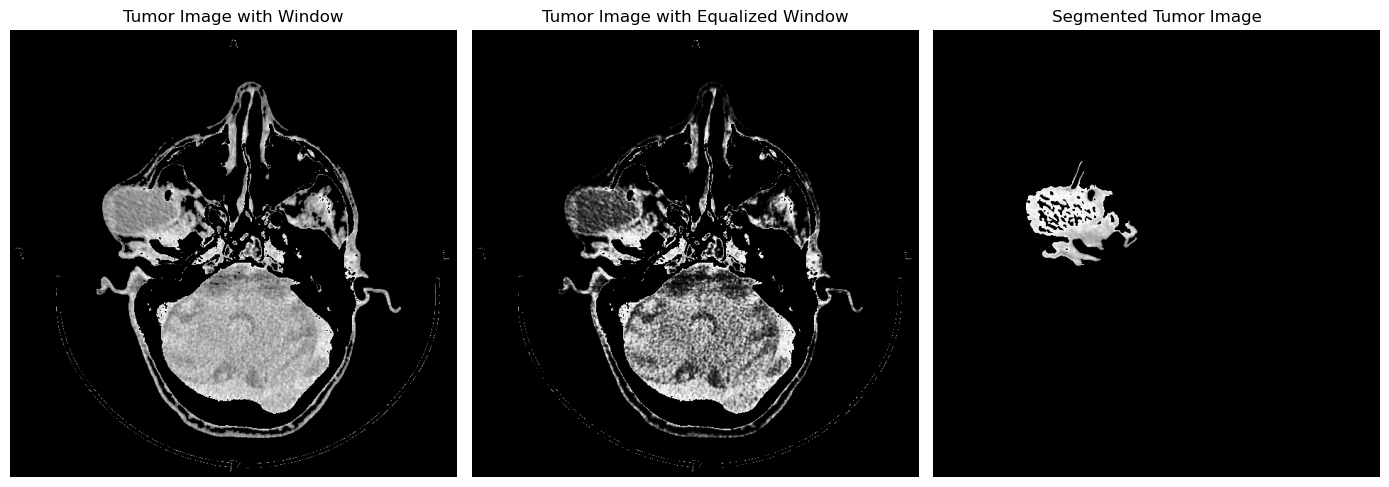

In [14]:
# Define window values and create the windowed image
w_tumor = np.where((tumor_brain >= 50) & (tumor_brain <= 160), tumor_brain, 0).astype(np.uint8)

# Perform custom histogram equalization
tumor_eq = equalize_hist(w_tumor)

# Segment the equalized windowed image using flood fill
seg_tumor_w = flood_fill(tumor_eq.copy(), seed_point_tumor, new_value_tumor, tolerance_tumor)
diff_tumor2 = tumor_eq - seg_tumor_w

# Display the images
fig = plt.figure(figsize=(14, 12))

gs = GridSpec(1, 3)
ax0 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[0,1])
ax1 = fig.add_subplot(gs[0,2])

ax0.imshow(w_tumor, cmap='gray')
ax0.set_title('Tumor Image with Window')
ax1.imshow(diff_tumor, cmap='gray')
ax1.set_title('Segmented Tumor Image')
ax3.imshow(tumor_eq, cmap='gray')
ax3.set_title('Tumor Image with Equalized Window')

for a in (ax0, ax1, ax3):
    a.axis('off')

plt.tight_layout()
plt.plot()
plt.show()

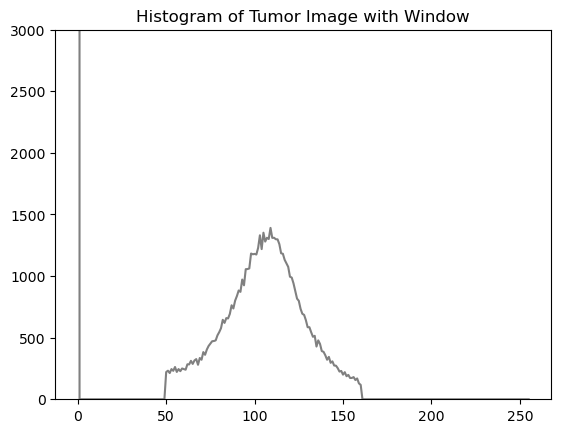

In [15]:
h, _ = np.histogram(w_tumor.flatten(), bins=256, range=(0, 256))
plt.plot(h, color="gray")
plt.title("Histogram of Tumor Image with Window")
plt.ylim(0,3000)
plt.show()

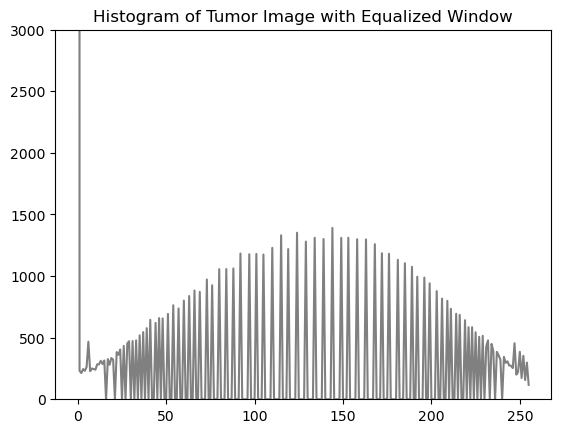

In [16]:
h, _ = np.histogram(tumor_eq.flatten(), bins=256, range=(0, 256))
plt.plot(h, color="gray")
plt.title("Histogram of Tumor Image with Equalized Window")
plt.ylim(0,3000)
plt.show()

Text(0.5, 1.0, 'Tumor with  histogram equalization')

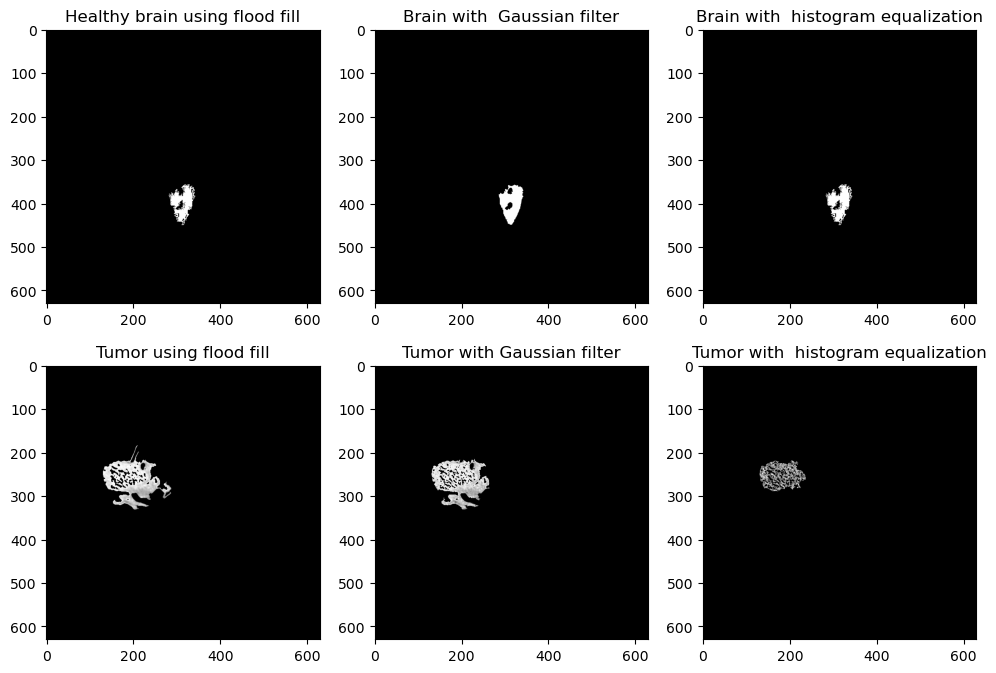

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(12,8))

# Displaying grayscale images on each subplot
axs[0, 0].imshow(diff_brain1, cmap='gray')
axs[0, 0].set_title('Healthy brain using flood fill')

axs[1,1].imshow(diff_tumor1, cmap='gray')
axs[1,0].set_title('Tumor using flood fill')

axs[0, 1].imshow(diff_brain, cmap='gray')
axs[0, 1].set_title('Brain with  Gaussian filter')

axs[1, 0].imshow(diff_tumor, cmap='gray')
axs[1, 1].set_title('Tumor with Gaussian filter')

axs[0,2].imshow(diff_brain2, cmap='gray')
axs[0,2].set_title('Brain with  histogram equalization')

axs[1, 2].imshow(diff_tumor2, cmap='gray')
axs[1, 2].set_title('Tumor with  histogram equalization')